In [6]:
#Python 3

import pandas as pd
import numpy as np
from xgboost import XGBClassifier as xg
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold

#First 37 Ramanujan primes
seed = [2, 11, 17, 29, 41, 47, 59, 67, 71, 97, 101, 107, 127, 149, 151, 167, 179, 181, 227, 229, 
        233, 239, 241, 263, 269, 281, 307, 311, 347, 349, 367, 373, 401, 409, 419, 431, 433]


def make_submission(csv_name, idx, preds):
    submission = pd.DataFrame({ 'id': idx,
                                'HOF': preds })
    submission.to_csv(csv_name + ".csv", index=False, columns = ['id', 'HOF'])


def estimator_bagging(model, X_train, y_train, X_cv):

    predictions = [0.0  for d in range(0, (X_cv.shape[0]))]

    for n in range (0, len(seed)):
        model.set_params(seed = seed[n])
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_cv)[:,1]
        for j in range (0, (X_cv.shape[0])):
                 predictions[j] += preds[j]

    for j in range (0, len(predictions)):
                 predictions[j] /= float(len(seed))

    return np.array(predictions)




model = xg(learning_rate=0.095, gamma=0.8, max_depth=5, subsample=0.9,
                min_child_weight=0.8, colsample_bytree=0.5,
                objective='binary:logistic', seed=seed)

print ('Reading data...')
X_train = pd.read_csv('combined_stats_train.csv', sep=',', header=0)
X_train = X_train.set_index('playerID')
y_train = X_train.ix[:,'HOF']
X_train.drop('HOF', axis=1, inplace=True)

X_test = pd.read_csv('combined_stats_test.csv', sep=',', header=0)
X_test = X_test.set_index('playerID')
id_test = X_test.index.values
    

print ('')
print ('Training data: ')
print ('Shape: ' + str(X_train.shape))
print (X_train.head())
print ('')


num_folds = 5 
num_trees = len(seed) 

mean_auc = 0.0
i = 0
folds = StratifiedKFold(y_train, n_folds=num_folds, shuffle=True, random_state=seed[6])

for trainIndex, testIndex in folds:
        X_train_part, x_crossval = X_train.iloc[trainIndex], X_train.iloc[testIndex]
        y_train_part, y_crossval = np.array(y_train)[trainIndex], np.array(y_train)[testIndex]

        preds = estimator_bagging(model, X_train_part, y_train_part, x_crossval)

        roc_auc = roc_auc_score(y_crossval, preds)
        mean_auc += roc_auc

        i += 1

mean_auc /= num_folds
print ('AUC: ' + str(mean_auc))


print ('Training...')
print ('Bagging parameters:')
print ('    Number of trees: %d' % (num_trees))
preds = estimator_bagging(model, X_train, y_train, X_test)
make_submission('predictions', id_test, preds)

print ('')
print ('Program complete!')
print ('')

#main()

Reading data...

Training data: 
Shape: (3391, 28)
            W    L    G   GS  CG  SHO  SV  IPouts     H   ER    ...      \
playerID                                                        ...       
aasedo01   66   60  448   91  22    5  82  3328.0  1085  468    ...       
abbeybe01  22   40   79   66  52    0   1  1704.0   686  285    ...       
abbotgl01  62   83  248  206  37    5   0  3858.0  1405  627    ...       
abbotji01  87  108  263  254  31    6   0  5022.0  1779  791    ...       
abbotky01   4   17   57   22   0    0   0   556.0   207  107    ...       

              GF    R  SH  SF       ERA  AllStar  MVP  CyYoung  \
playerID                                                         
aasedo01   234.0  503 NaN NaN  3.796875      1.0  0.0      0.0   
abbeybe01   12.0  442 NaN NaN  4.515845      NaN  NaN      NaN   
abbotgl01   13.0  707 NaN NaN  4.388025      0.0  0.0      0.0   
abbotji01    5.0  880 NaN NaN  4.252688      0.0  0.0      0.0   
abbotky01    4.0  112 NaN N

(751, 28)

In [8]:
z = np.zeros(28).reshape(1,28)
z[0,0] = 10000
z = pd.DataFrame(z, columns=X_test.columns)
preds = estimator_bagging(model, X_train, y_train, z)
print (preds)

[ 0.16833635]


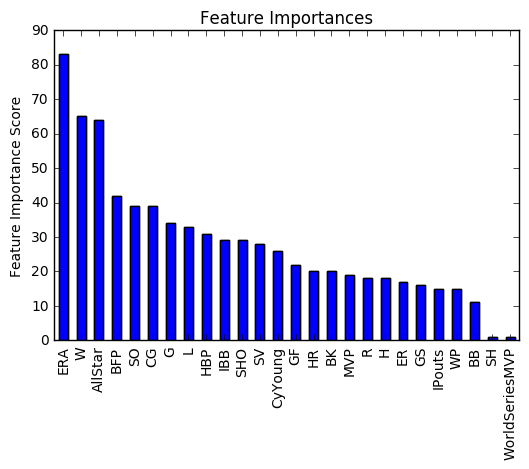

In [10]:
import matplotlib.pyplot as plt
feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

Reading data...
Average number of games played by HOFer: 573

Training data: 
Shape: (3395, 30)
            W    L    G   GS  CG  SHO  SV  IPouts     H   ER    ...      SH  \
playerID                                                        ...           
aasedo01   66   60  448   91  22    5  82    3328  1085  468    ...     NaN   
abbeybe01  22   40   79   66  52    0   1    1704   686  285    ...     NaN   
abbotgl01  62   83  248  206  37    5   0    3858  1405  627    ...     NaN   
abbotji01  87  108  263  254  31    6   0    5022  1779  791    ...     NaN   
abbotky01   4   17   57   22   0    0   0     556   207  107    ...     NaN   

           SF       ERA  Mitchell-Report  Positive-Test  AllStar  MVP  \
playerID                                                                
aasedo01  NaN  3.796875                0              0      1.0  0.0   
abbeybe01 NaN  4.515845                0              0      NaN  NaN   
abbotgl01 NaN  4.388025                0              0   

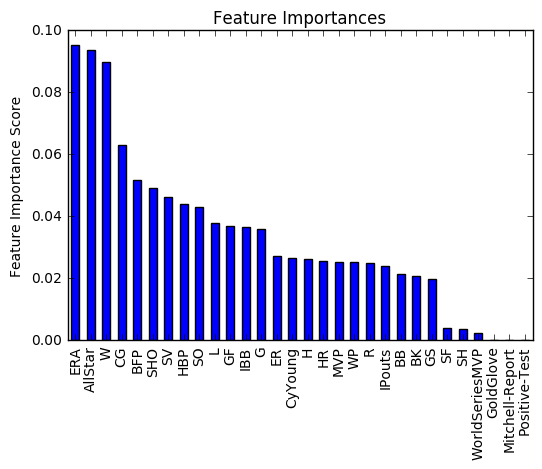


Program complete!



In [3]:
#Python 3

import pandas as pd
import numpy as np
import math
from xgboost import XGBClassifier as xg
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold

#First 37 Ramanujan primes
seed = [2, 11, 17, 29, 41, 47, 59, 67, 71, 97, 101, 107, 127, 149, 151, 167, 179, 181, 227, 229, 
        233, 239, 241, 263, 269, 281, 307, 311, 347, 349, 367, 373, 401, 409, 419, 431, 433]


def make_submission(csv_name, idx, preds):
    submission = pd.DataFrame({ 'id': idx,
                                'HOF': preds })
    submission.to_csv(csv_name + ".csv", index=False, columns = ['id', 'HOF'])


def estimator_bagging(model, X_train, y_train, X_cv):

    predictions = [0.0  for d in range(0, (X_cv.shape[0]))]
    feature_import = [0.0 for d in range(0, (X_train.shape[1]))]

    for n in range (0, len(seed)):
        model.set_params(seed = seed[n])
        model.fit(X_train, y_train)
        for i in range(0, (X_train.shape[1])):
            feature_import[i] += model.feature_importances_[i]
        preds = model.predict_proba(X_cv)[:,1]
        for j in range (0, (X_cv.shape[0])):
            predictions[j] += preds[j]
    
    for i in range (0, len(feature_import)):
        feature_import[i] /= float(len(seed))
    for j in range (0, len(predictions)):
        predictions[j] /= float(len(seed))

    return np.array(predictions), np.array(feature_import)


def scale_games(X_test, average_games):
    
    for p in X_test.index:
        scale_val = average_games / X_test.loc[p, 'G']
        for f in list(X_test):
            if f in ['ERA', 'Mitchell-Report', 'Positive-Test', 'MVP', 'CyYoung', 'WorldSeriesMVP', 'GoldGlove']:
                continue
            X_test.loc[p, f] *= scale_val
    
def main():

    model = xg(learning_rate=0.095, gamma=0.8, max_depth=5, subsample=0.9,
                min_child_weight=0.8, colsample_bytree=0.5,
                objective='binary:logistic', seed=seed)

    print ('Reading data...')
    X_train = pd.read_csv('combined_stats_train.csv', sep=',', header=0)
    df = X_train.loc[X_train['HOF'] == 1]
    avg_games = math.floor(df['G'].mean())
    print("Average number of games played by HOFer: "+str(avg_games))
    X_train = X_train.set_index('playerID')
    y_train = X_train.ix[:,'HOF']
    X_train.drop('HOF', axis=1, inplace=True)

    X_test = pd.read_csv('combined_stats_test.csv', sep=',', header=0)
    X_test = X_test.set_index('playerID')
    id_test = X_test.index.values
    

    print ('')
    print ('Training data: ')
    print ('Shape: ' + str(X_train.shape))
    print (X_train.head())
    print ('')


    num_folds = 5 
    num_trees = len(seed) 

    mean_auc = 0.0
    i = 0
    folds = StratifiedKFold(y_train, n_folds=num_folds, shuffle=True, random_state=seed[0])

    for trainIndex, testIndex in folds:
        X_train_part, x_crossval = X_train.iloc[trainIndex], X_train.iloc[testIndex]
        y_train_part, y_crossval = np.array(y_train)[trainIndex], np.array(y_train)[testIndex]

        preds, feats = estimator_bagging(model, X_train_part, y_train_part, x_crossval)

        roc_auc = roc_auc_score(y_crossval, preds)
        mean_auc += roc_auc

        i += 1

    mean_auc /= num_folds
    print ('AUC: ' + str(mean_auc))


    print ('Training...')
    print ('Bagging parameters:')
    print ('    Number of trees: %d' % (num_trees))
    preds, feats = estimator_bagging(model, X_train, y_train, X_test)
    make_submission('predictions', id_test, preds)

    feat_imp = pd.Series(feats, index=X_train.columns).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    pyplot.ylabel('Feature Importance Score')
    pyplot.show()

    scale_games(X_test, avg_games)
    X_test.to_csv("scaled_stats.csv")

    preds, feats = estimator_bagging(model, X_train, y_train, X_test)
    make_submission('scaled-predictions', id_test, preds)

    print ('')
    print ('Program complete!')
    print ('')

main()
